# Projet PRONTO ‚Äì Analyse et g√©n√©ration de signaux physiologiques

Ce notebook a √©t√© r√©alis√© dans le cadre de l'UE PRONTO √† l'IMT Atlantique (site de Nantes) en 2025.  
Il a pour objectif de g√©n√©rer des signaux physiologiques synth√©tiques r√©alistes (typiquement : fr√©quence cardiaque) √† partir de donn√©es exp√©rimentales, en extrayant puis en restituant les caract√©ristiques essentielles du signal.

## √âquipe projet
- Victor CLAQUIN  
- Adam DENIEULLE  
- Sedki GHARSALLAH  
- Houcine OUSTANI  
**Encadrant** : Monsieur Charles PRUD‚ÄôHOMME

---

## Objectifs du pipeline
1. **Chargement** et d√©coupage temporel du signal r√©el.
2. **D√©tection des R-peaks** pour mesurer les intervalles R-R.
3. **Analyse d‚Äôamplitude** des battements via enveloppe.
4. **Extraction de la tendance lente** du signal.
5. **G√©n√©ration d‚Äôun signal synth√©tique**, battement par battement.
6. **Ajout de bruit** (sur amplitude, largeur, tendance).
7. **Visualisation anim√©e** sous forme de GIF type √©lectrocardiogramme.

> Le code est organis√© de mani√®re modulaire, avec des classes d√©di√©es dans des fichiers s√©par√©s (`data_loader.py`, `peak_detector.py`, `amplitude_analyzer.py`, `signal_generator.py`, etc.).




## Initialisation du notebook

Cette section configure le notebook pour qu‚Äôil puisse acc√©der aux modules Python d√©finis dans le dossier `scr/`.  
On y importe √©galement toutes les classes n√©cessaires au traitement des signaux physiologiques :

- `DataLoader` : chargement et d√©coupage des donn√©es
- `PeakDetector` : d√©tection des R-peaks
- `AmplitudeAnalyzer` : extraction des enveloppes et hauteurs de battements
- `TrendExtractor` : extraction de la tendance lente
- `SignalGenerator` : g√©n√©ration de signaux synth√©tiques
- `NoiseInjector` : ajout optionnel de bruit r√©aliste


In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scr_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'scr'))
if scr_path not in sys.path:
    sys.path.append(scr_path)

# Imports internes
from data_loader import DataLoader
from peak_detector import PeakDetector
from amplitude_analyzer import AmplitudeAnalyzer
from trend_extractor import TrendExtractor
from signal_generator import SignalGenerator
from noise_injector import NoiseInjector

## Chargement des donn√©es physiologiques

Dans cette section, nous chargeons les donn√©es physiologiques brutes depuis un fichier `.txt` extrait du TP exp√©rimental.  
Le fichier contient plusieurs signaux (pression art√©rielle, fr√©quence cardiaque, etc.) mesur√©s √† 200 Hz.

Les param√®tres suivants sont d√©finis :
- `filepath` : chemin d'acc√®s au fichier contenant les mesures physiologiques
- `interval_ms` : intervalle d'√©chantillonnage (ici 5 ms, soit 200 Hz)
- `start_time`, `end_time` : plage temporelle d'analyse (ici de 0 √† 250 secondes)

Apr√®s chargement, les donn√©es sont nettoy√©es, converties en format num√©rique, et un affichage graphique des signaux bruts est produit.


Donn√©es charg√©es : 51137 lignes
Dur√©e totale du fichier : 255.68 s
Plage extraite : 0.00 s ‚Üí 250.00 s


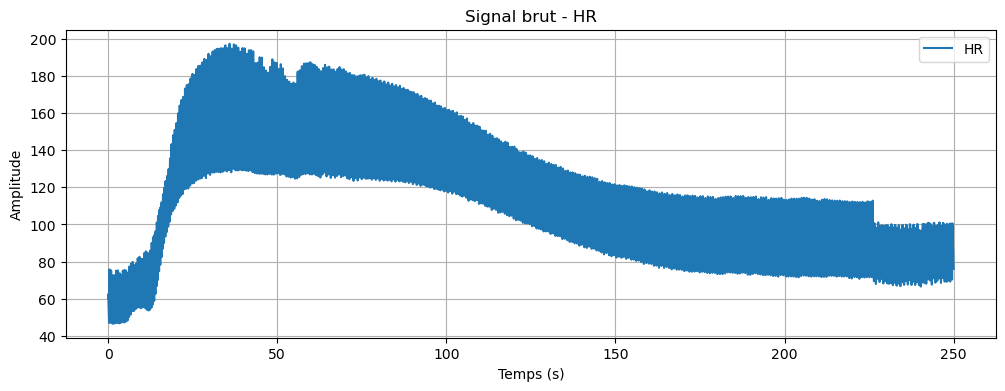

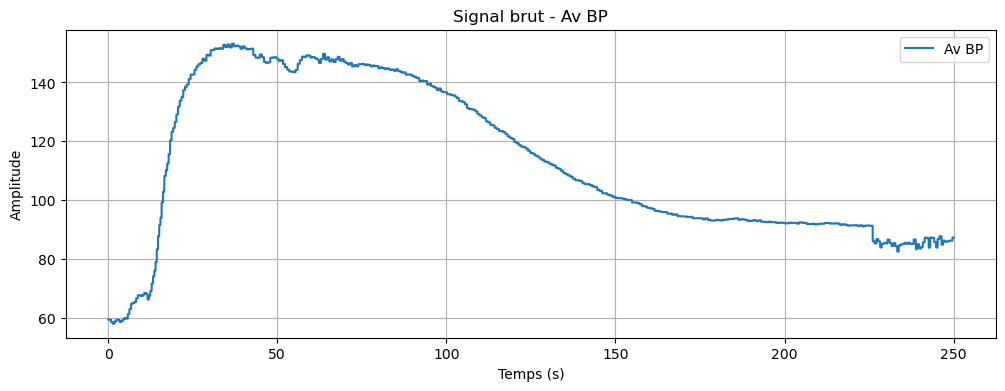

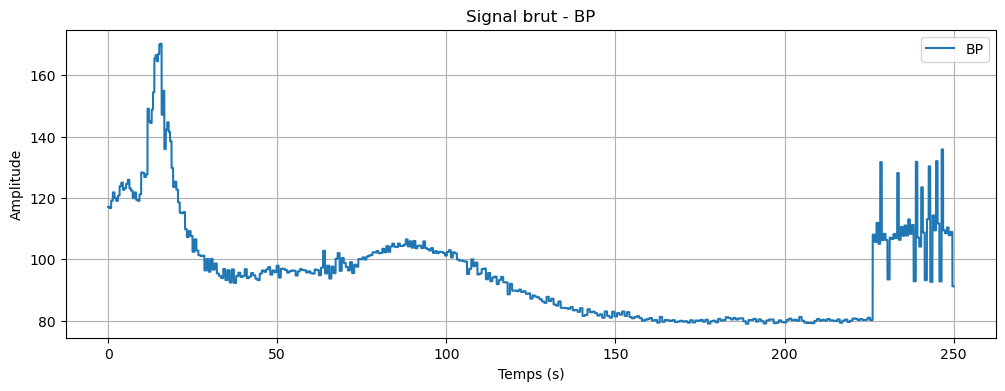

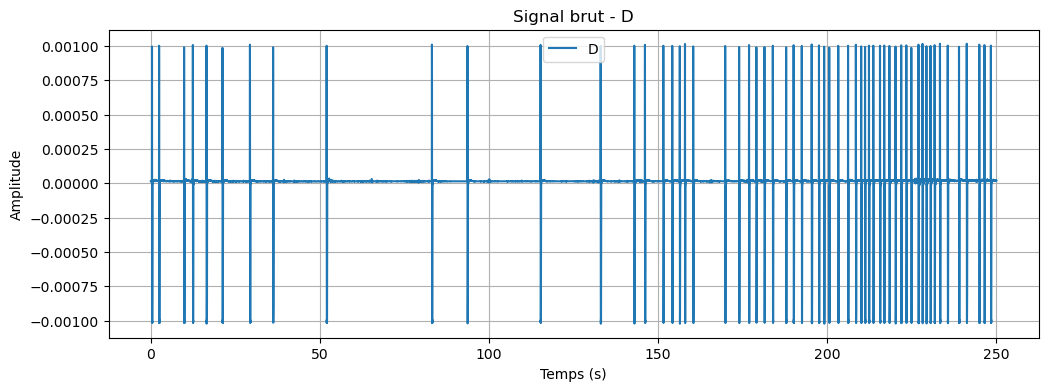

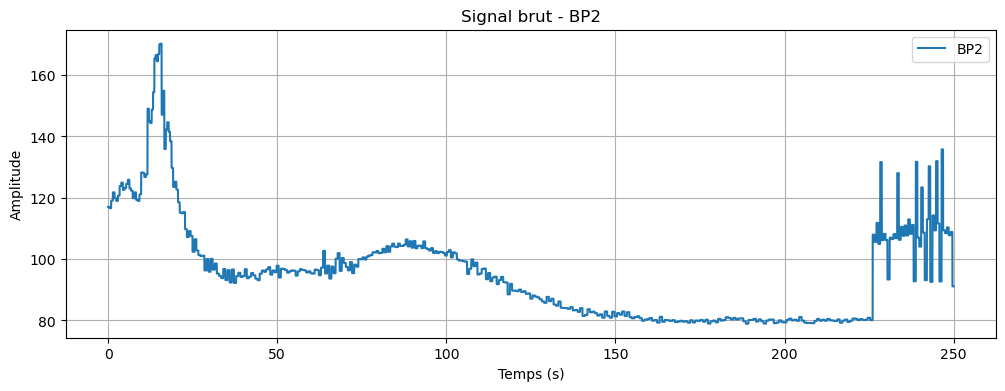

In [2]:

# Param√®tres du signal
filepath = "../data/data1/Adrenaline.txt"   
interval_ms = 5
start_time = 0
end_time = 250

sampling_rate = 1000 / interval_ms  # = 200 Hz ici

# Chargement et d√©coupage
loader = DataLoader(filepath, interval_ms)
df_full = loader.load()
df_crop = loader.crop_time_range(start_time, end_time)

# Informations sur les donn√©es
total_time = df_full["Time"].max() - df_full["Time"].min()
print(f"Donn√©es charg√©es : {df_full.shape[0]} lignes")
print(f"Dur√©e totale du fichier : {total_time:.2f} s")
print(f"Plage extraite : {df_crop['Time'].min():.2f} s ‚Üí {df_crop['Time'].max():.2f} s")

# Aper√ßu des 5 premi√®res lignes extraites
df_crop.head()

# Affichage des signaux bruts
loader.plot(df_crop)



## D√©tection des R-peaks et analyse des intervalles R-R

Nous d√©tectons ici les R-peaks (pics caract√©ristiques de l'activit√© cardiaque) √† partir du signal de fr√©quence cardiaque (`HR`).  
L‚Äôalgorithme utilis√© repose sur la m√©thode `find_peaks` de SciPy, configur√©e pour respecter une distance minimale entre battements (`distance_sec`) et une pro√©minence minimale (`prominence`).

Cette d√©tection permet :
- de localiser les battements cardiaques,
- de calculer les intervalles R-R (temps entre deux battements successifs),
- d‚Äôestimer la fr√©quence cardiaque moyenne.

Les r√©sultats sont affich√©s sous forme :
- d‚Äôun graphe avec les R-peaks superpos√©s au signal global et sur une fen√™tre zoom√©e,
- d‚Äôun graphe d√©di√© aux intervalles R-R.


R-R Manual (SciPy) : {'mean_rr_interval_s': 0.6358801020408162, 'std_rr_interval_s': 0.09225659321602074, 'num_beats': 393, 'heart_rate_bpm': 94.35741078771589}


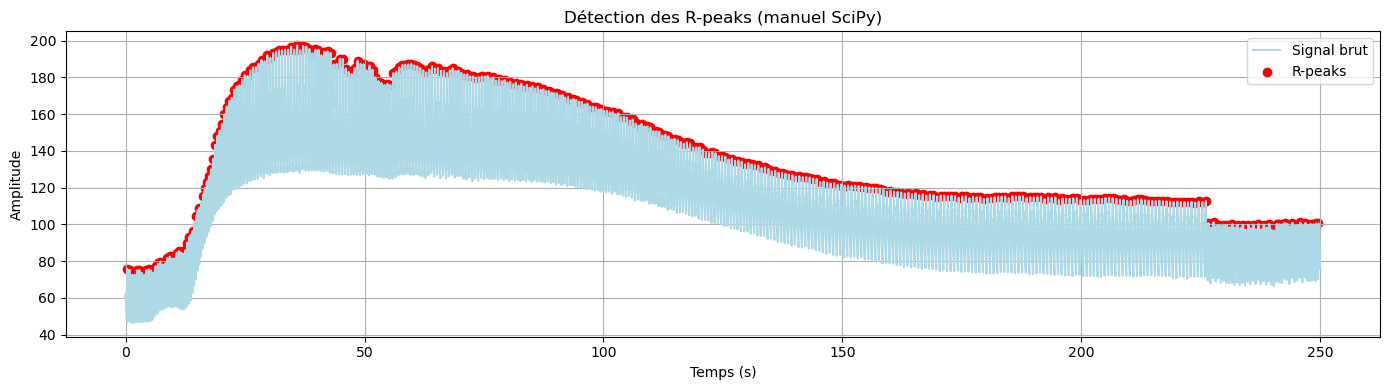

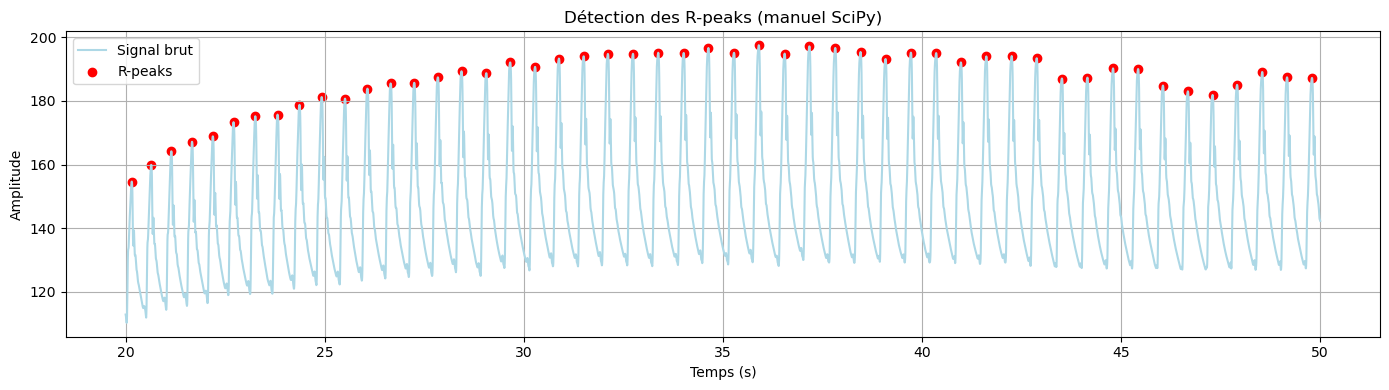

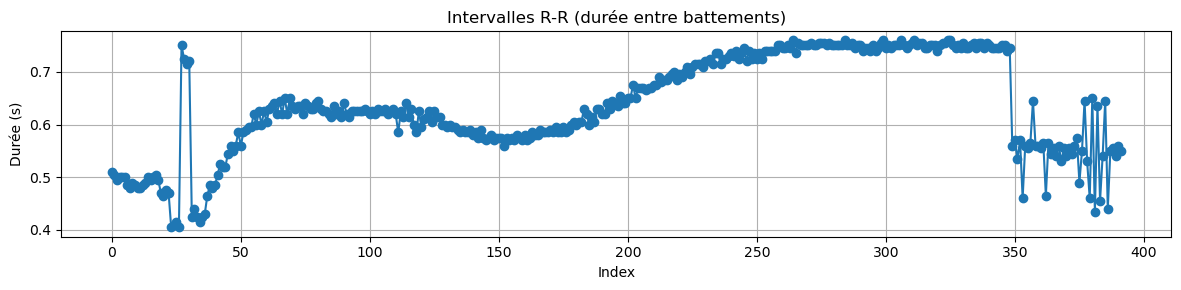

In [3]:
# Param√®tres
signal = df_crop["HR"].values
time = df_crop["Time"].values

# D√©tection manuelle
detector = PeakDetector(signal=signal, time=time, sampling_rate=sampling_rate)
rpeaks, rr_intervals = detector.detect_r_peaks_manual(distance_sec=0.4, prominence=3)

# Statistiques
stats = detector.get_rr_stats()
print("R-R Manual (SciPy) :", stats)

# Affichage global + zoom√©
detector.plot_r_peaks()
detector.plot_r_peaks(zoom_start=20, zoom_end=50)

# Graphe des intervalles R-R
detector.plot_rr_intervals()


## Analyse de l‚Äôamplitude des battements cardiaques

Ce bloc permet d‚Äôestimer l‚Äôamplitude des battements cardiaques √† partir du signal `HR`, en extrayant une **enveloppe sup√©rieure et inf√©rieure** autour du signal.

Trois m√©thodes d‚Äôextraction sont compar√©es :
1. **Enveloppe de Hilbert** : bas√©e sur le signal analytique complexe.
2. **Interpolation lin√©aire des pics max/min** : cr√©e une enveloppe en reliant les sommets d√©tect√©s.
3. **Fen√™tre glissante min/max** : calcule localement les bornes d‚Äôamplitude avec un fen√™trage d√©fini.

L‚Äôamplitude instantan√©e est ensuite d√©finie comme la **diff√©rence entre l‚Äôenveloppe sup√©rieure et inf√©rieure**, et des statistiques globales (moyenne, √©cart-type, min, max) sont calcul√©es.

Ces informations sont cruciales pour :
- ajuster la hauteur des battements cardiaques dans le signal g√©n√©r√©,
- simuler la variabilit√© naturelle de l‚Äôintensit√© des battements.


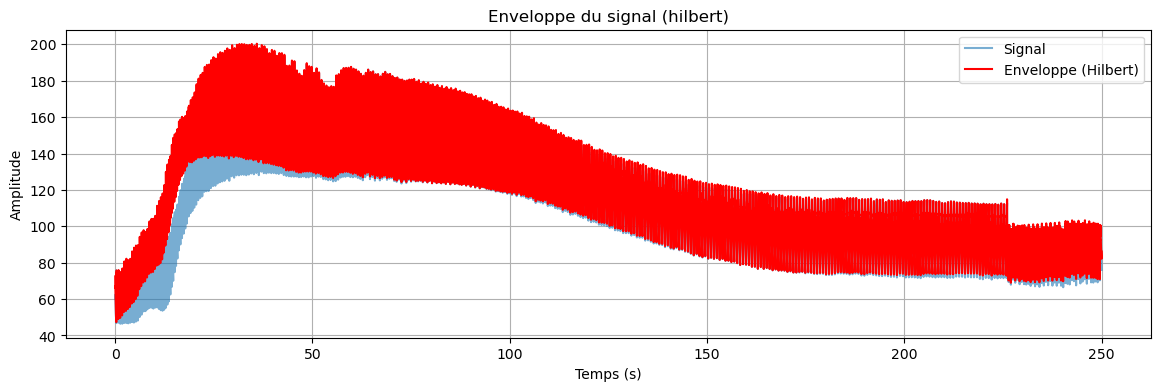

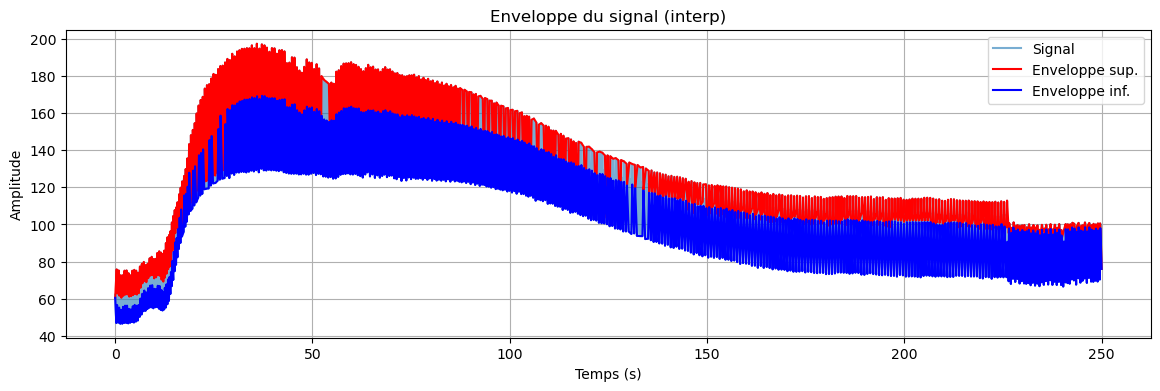

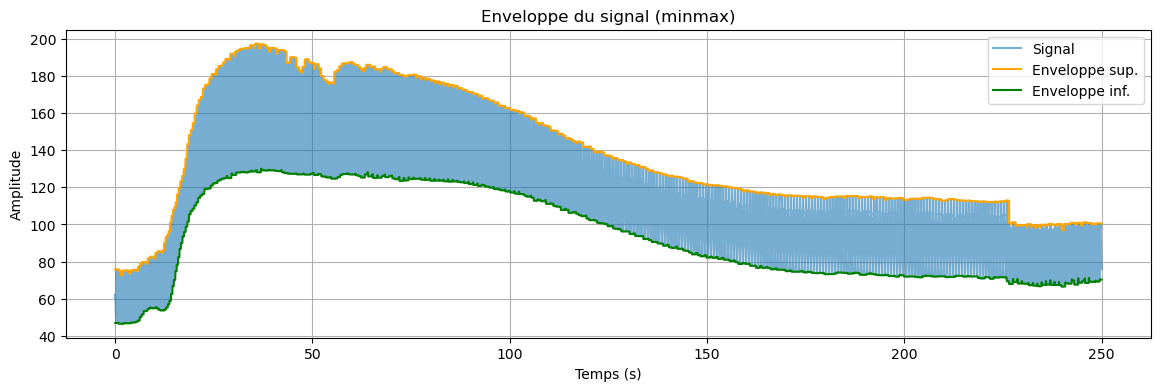

Statistiques d‚Äôamplitude (minmax): {'mean_amplitude': 44.30432931341373, 'std_amplitude': 10.165781002392425, 'min_amplitude': 24.440000000000005, 'max_amplitude': 69.37}


In [4]:
# Param√®tres
signal = df_crop["HR"].values
time = df_crop["Time"].values

# Analyse d‚Äôamplitude avec enveloppes
ampl_analyzer = AmplitudeAnalyzer(signal=signal, time=time, sampling_rate=sampling_rate)

# 1. Enveloppe de Hilbert
ampl_analyzer.compute_hilbert_envelope()
ampl_analyzer.plot_envelope(method="hilbert")

# 2. Enveloppe par interpolation des pics
ampl_analyzer.compute_interpolated_envelope()
ampl_analyzer.plot_envelope(method="interp")

# 3. Enveloppe par min-max glissant
upper, lower = ampl_analyzer.compute_minmax_envelope(window_size=200)
ampl_analyzer.plot_envelope(method="minmax")

# 4. Analyse statistique sur cette enveloppe
amplitudes_array = upper - lower
amplitude_stats = {
    "mean_amplitude": np.mean(amplitudes_array),
    "std_amplitude": np.std(amplitudes_array),
    "min_amplitude": np.min(amplitudes_array),
    "max_amplitude": np.max(amplitudes_array),
}
print("Statistiques d‚Äôamplitude (minmax):", amplitude_stats)


## Extraction de la tendance lente du signal

Cette section a pour but de d√©gager une **tendance globale** du signal de fr√©quence cardiaque (`HR`), c‚Äôest-√†-dire son √©volution lente au fil du temps. Cette tendance sera utilis√©e pour moduler le signal g√©n√©r√©, afin de reproduire les variations physiologiques de fond.

Trois m√©thodes sont test√©es :
1. **Moyenne glissante centr√©e** : calcule une moyenne locale avec un fen√™trage large, tout en g√©rant les bords gr√¢ce √† un **padding miroir**.
2. **Spline cubique liss√©e** : ajuste une courbe souple aux donn√©es, en tenant compte d‚Äôun facteur de lissage.
3. **Moyenne des deux m√©thodes** : permet de combiner les avantages des approches pr√©c√©dentes pour une estimation plus robuste.

Chaque m√©thode est visualis√©e pour √©valuer sa pertinence sur les signaux bruts.


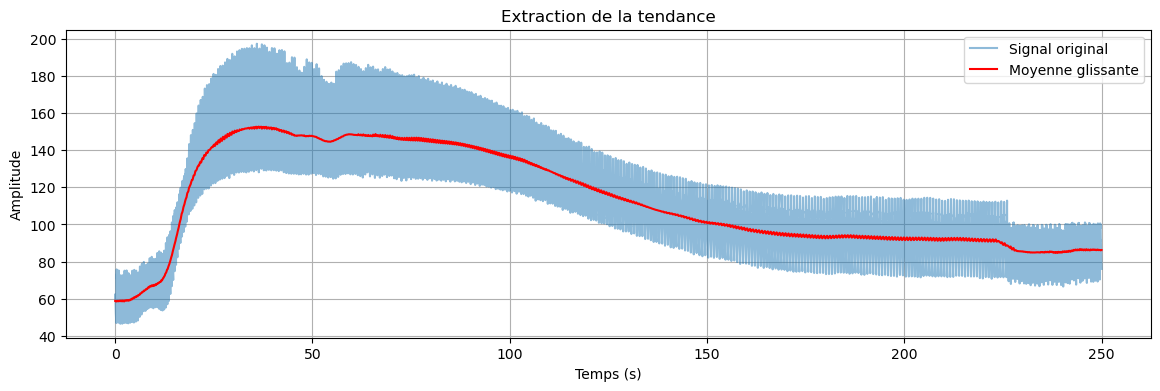

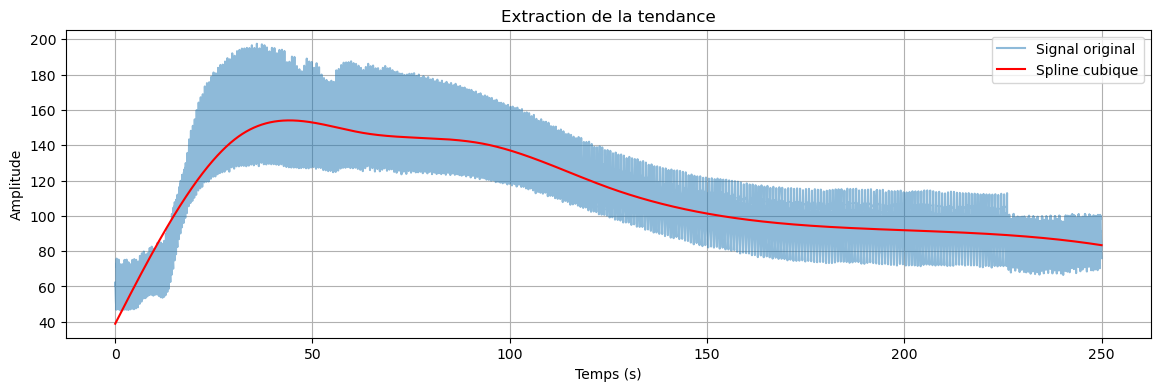

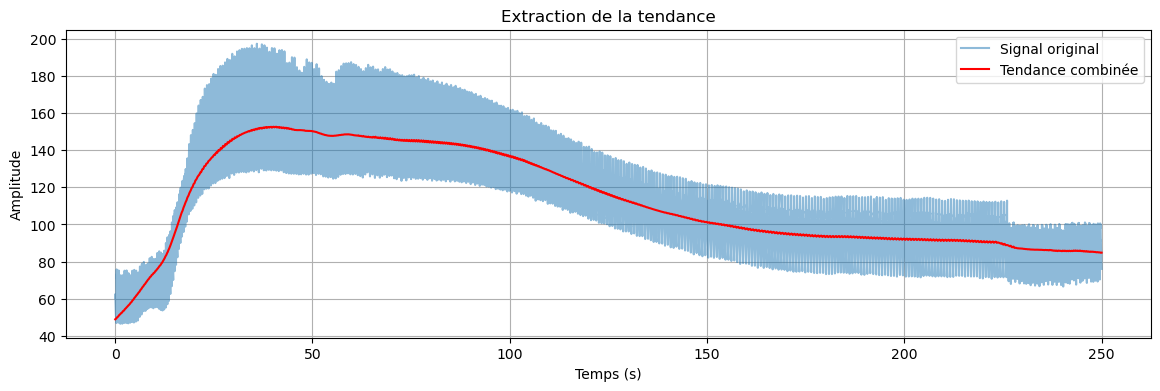

In [5]:

# Initialisation
trend_ex = TrendExtractor(signal=signal, time=time)

# 1 Moyenne glissante avec padding miroir
trend_rolling = trend_ex.extract_rolling_mean(window_size=1001)
trend_ex.plot_trend(label="Moyenne glissante")

# 2Ô∏è Spline cubique
trend_spline = trend_ex.extract_spline(smooth_factor=1e7)
trend_ex.plot_trend(label="Spline cubique")

# 3Ô∏è Moyenne des deux
trend_combined = trend_ex.extract_combined(rolling_window=1001, smooth_factor=1e7)
trend_ex.plot_trend(label="Tendance combin√©e")


## G√©n√©ration du signal synth√©tique

√Ä partir des informations extraites pr√©c√©demment (intervalles R-R, amplitude locale et tendance), nous g√©n√©rons un **signal physiologique synth√©tique** imitant un ECG.

Les √©tapes sont les suivantes :
1. **Initialisation du g√©n√©rateur** : la classe `SignalGenerator` produit des battements de c≈ìur artificiels √† partir de gaussiennes param√©tr√©es.
2. **D√©termination des amplitudes** : on extrait l'enveloppe (diff√©rence entre les courbes sup√©rieure et inf√©rieure) aux positions des R-peaks.
3. **Ajustement de taille** : on aligne le nombre d‚Äôamplitudes sur celui des intervalles R-R d√©tect√©s.
4. **G√©n√©ration du signal "plat"** : on aligne les motifs cardiaques battement par battement.
5. **Application de la tendance** : on modifie le signal pour qu‚Äôil suive la variation lente observ√©e dans le signal original.
6. **Comparaison visuelle** : on superpose le signal synth√©tique et le signal r√©el sur la m√™me plage temporelle pour juger de la fid√©lit√© de la reproduction.


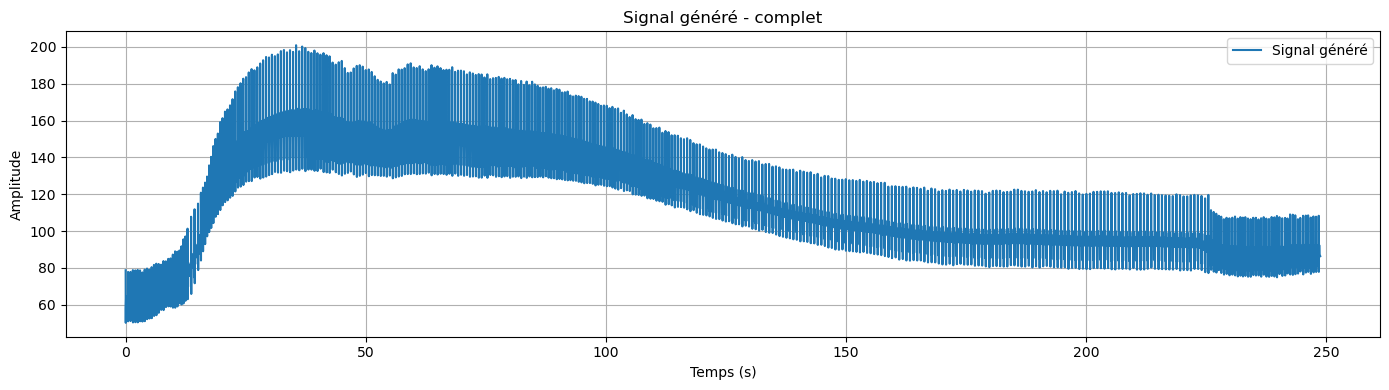

/var/folders/qm/j5wmzzcj5c984rjjdqscj5hh0000gn/T/ipykernel_76930/3989210459.py:51: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


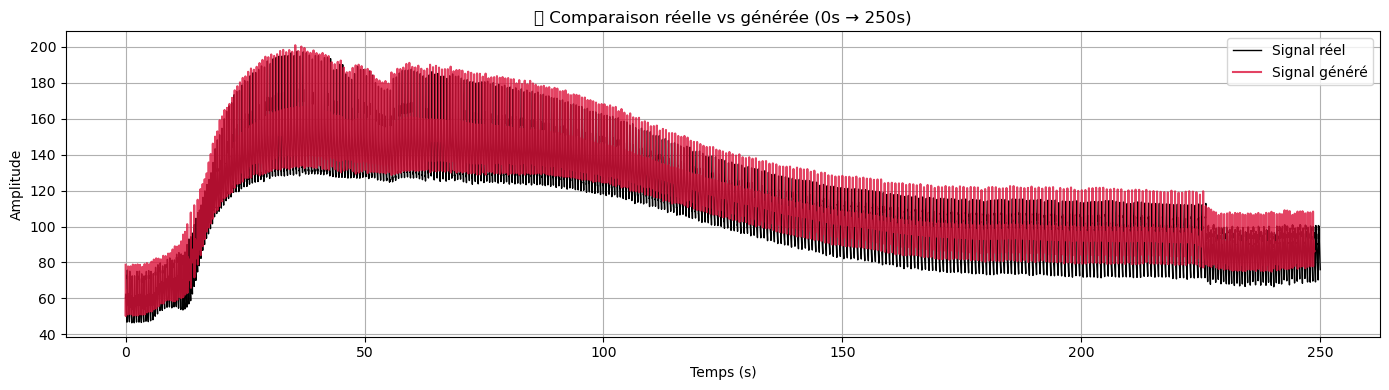

In [6]:
# G√©n√©ration du signal battement par battement

# Initialisation du g√©n√©rateur
generator = SignalGenerator(sampling_rate=sampling_rate)

# Extraction de l‚Äôamplitude locale
amplitudes_array = upper - lower
amplitudes_array = amplitudes_array[rpeaks[:-1]]

# Ajustement taille si n√©cessaire
if len(amplitudes_array) > len(rr_intervals):
    amplitudes_array = amplitudes_array[:len(rr_intervals)]
elif len(amplitudes_array) < len(rr_intervals):
    rr_intervals = rr_intervals[:len(amplitudes_array)]

# G√©n√©ration du signal plat
signal_flat = generator.tile_signal_from_arrays(
    rr_intervals=rr_intervals,
    amplitudes=amplitudes_array
)

# Application de la tendance
signal_final = generator.apply_trend(trend_rolling)

# Visualisation du signal g√©n√©r√©
generator.plot(title="Signal g√©n√©r√© - complet")

# PARAM√àTRES DE ZOOM POUR LA COMPARAISON
zoom_start = start_time
zoom_end = end_time

# Extraction du signal r√©el dans l‚Äôintervalle
mask_real = (df_crop["Time"] >= zoom_start) & (df_crop["Time"] <= zoom_end)
time_real = df_crop["Time"].values[mask_real]
signal_real = df_crop["HR"].values[mask_real]

# Extraction du signal g√©n√©r√© dans le m√™me intervalle
mask_gen = (generator.time >= zoom_start) & (generator.time <= zoom_end)
time_gen = generator.time[mask_gen]
signal_gen = signal_final[mask_gen]

# Affichage comparatif
plt.figure(figsize=(14, 4))
plt.plot(time_real, signal_real, label="Signal r√©el", color="black", linewidth=1)
plt.plot(time_gen, signal_gen, label="Signal g√©n√©r√©", color="crimson", alpha=0.8)
plt.title(f"üîç Comparaison r√©elle vs g√©n√©r√©e ({zoom_start}s ‚Üí {zoom_end}s)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Ajout de bruit r√©aliste et comparaison finale

Pour simuler un signal physiologique plus proche de la r√©alit√©, on injecte du **bruit contr√¥l√©** dans les composantes suivantes :
- **R-R intervals** : fluctuations dans la fr√©quence cardiaque,
- **Amplitude** : variabilit√© dans la force des battements,
- **Tendance lente** : d√©rive globale du signal.

L‚Äôobjectif est d‚Äôobtenir un signal **g√©n√©r√© bruit√©** qui conserve les propri√©t√©s globales du signal original tout en y introduisant des **irr√©gularit√©s naturelles**.

Les √©tapes sont les suivantes :
1. **G√©n√©ration du bruit** via la classe `NoiseInjector` avec un `seed` pour la reproductibilit√©.
2. **Production d‚Äôun nouveau signal** √† partir des donn√©es bruit√©es.
3. **Visualisation comparative** :
   - Signal r√©el,
   - Signal g√©n√©r√© sans bruit,
   - Signal g√©n√©r√© avec bruit.

Cette √©tape valide la capacit√© de notre simulateur √† imiter des signaux r√©alistes, tout en offrant une variabilit√© naturelle utile √† des fins de simulation ou d'entra√Ænement algorithmique.


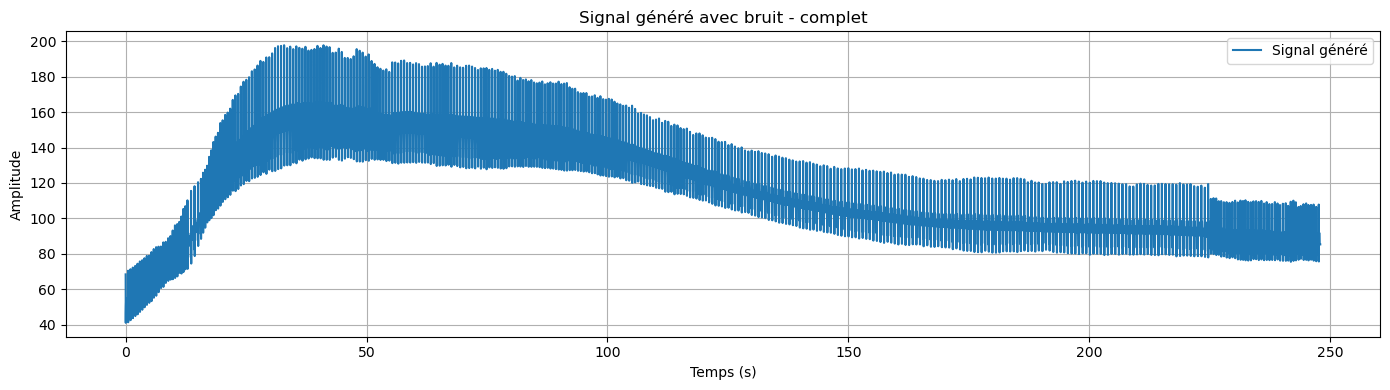

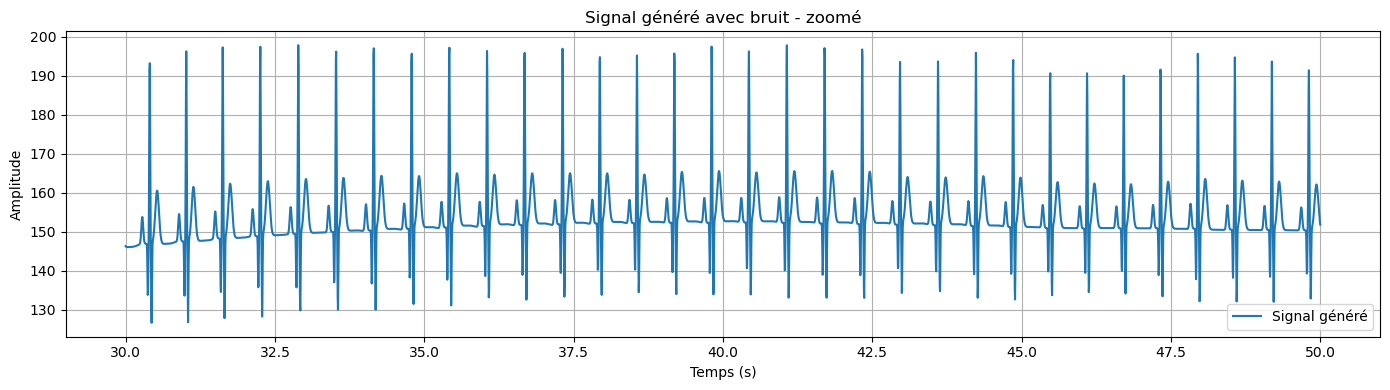

/var/folders/qm/j5wmzzcj5c984rjjdqscj5hh0000gn/T/ipykernel_76930/2655852674.py:46: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()


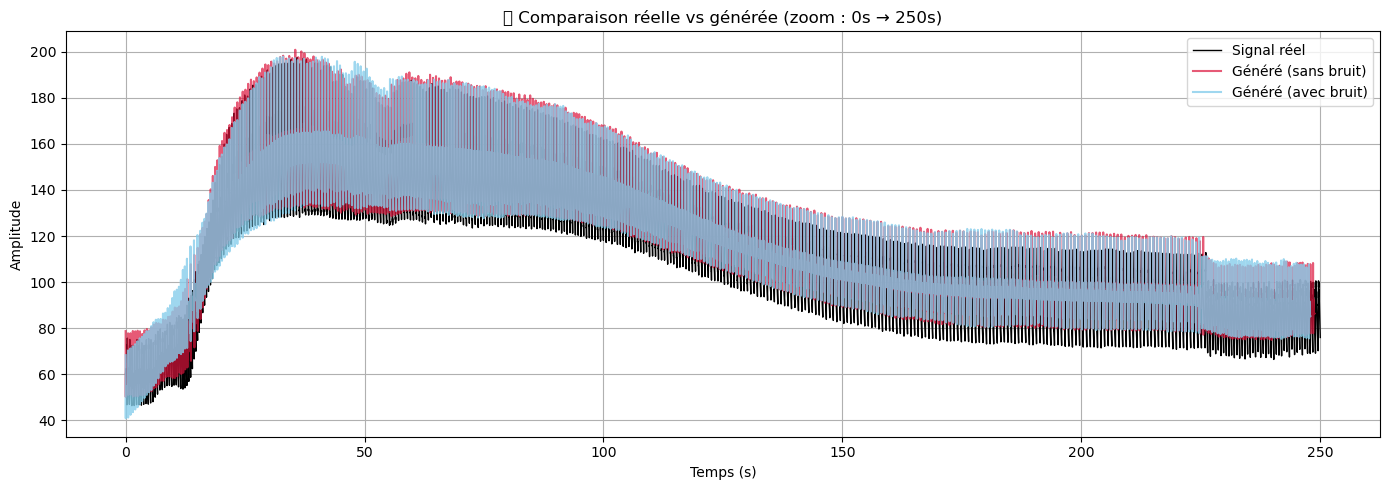

In [7]:
# Injection de bruit
injector = NoiseInjector(seed=42)

rr_intervals_noisy = injector.add_noise_to_rr(rr_intervals, noise_std=0.02)
amplitudes_noisy = injector.add_noise_to_amplitudes(amplitudes_array, noise_std=0.08)
trend_noisy = injector.add_noise_to_trend(trend_combined, noise_std=0.02)

# G√©n√©ration du signal avec bruit
generator_noisy = SignalGenerator(sampling_rate=sampling_rate)
signal_flat_noisy = generator_noisy.tile_signal_from_arrays(
    rr_intervals=rr_intervals_noisy,
    amplitudes=amplitudes_noisy
)
signal_final_noisy = generator_noisy.apply_trend(trend_noisy)

# Visualisation
generator_noisy.plot(title="Signal g√©n√©r√© avec bruit - complet")
generator_noisy.plot(zoom_start=30, zoom_end=50, title="Signal g√©n√©r√© avec bruit - zoom√©")

# Comparaison r√©elle vs g√©n√©r√© vs bruit√© sur une plage donn√©e
zoom_start = start_time
zoom_end = end_time

mask_real = (df_crop["Time"] >= zoom_start) & (df_crop["Time"] <= zoom_end)
time_real = df_crop["Time"].values[mask_real]
signal_real = df_crop["HR"].values[mask_real]

mask_gen = (generator.time >= zoom_start) & (generator.time <= zoom_end)
time_gen = generator.time[mask_gen]
signal_gen = signal_final[mask_gen]

mask_noisy = (generator_noisy.time >= zoom_start) & (generator_noisy.time <= zoom_end)
time_gen_noisy = generator_noisy.time[mask_noisy]
signal_gen_noisy = signal_final_noisy[mask_noisy]

# Affichage superpos√©
plt.figure(figsize=(14, 5))
plt.plot(time_real, signal_real, label="Signal r√©el", color="black", linewidth=1)
plt.plot(time_gen, signal_gen, label="G√©n√©r√© (sans bruit)", color="crimson", alpha=0.7)
plt.plot(time_gen_noisy, signal_gen_noisy, label="G√©n√©r√© (avec bruit)", color="skyblue", alpha=0.8)
plt.title(f"üîç Comparaison r√©elle vs g√©n√©r√©e (zoom : {zoom_start}s ‚Üí {zoom_end}s)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## G√©n√©ration d‚Äôun GIF type √©lectrocardiogramme (cardiogramme anim√©)

Pour rendre la visualisation plus intuitive et dynamique, nous avons cr√©√© une animation **type ECG** qui fait d√©filer le signal g√©n√©r√© bruit√© dans une fen√™tre glissante de 5 secondes.

Cette animation est produite √† l‚Äôaide de la classe `CardioVisualizer`, qui prend en entr√©e :
- Le signal g√©n√©r√© (avec ou sans bruit),
- Le vecteur temporel associ√©,
- Une fen√™tre glissante (en secondes),
- Une plage temporelle cibl√©e √† afficher (ici de 30s √† 60s).

Le r√©sultat est sauvegard√© sous forme de fichier `.gif` et permet d‚Äôillustrer le comportement temporel du signal simul√©, dans une perspective proche de celle d‚Äôun vrai appareil ECG.

‚ö†Ô∏è √Ä noter : cette animation peut √™tre gourmande en ressources ou parfois instable selon les syst√®mes ou d√©pendances Python. V√©rifier que le dossier `output/` existe bien, et que les biblioth√®ques telles que `pillow` sont install√©es.


In [8]:
from cardio_visualizer import CardioVisualizer

# Exemple : anim sur le segment 30s √† 60s
viz = CardioVisualizer(
    signal=signal_final_noisy,
    time=generator.time,
    window_seconds=5,
    start_time=30,
    end_time=60
)

viz.animate("output/cardiogramme_final.gif")
